### Importing Dependencies

In [1]:
%%bash
pip install numpy scipy librosa unidecode inflect librosa
apt-get update
apt-get install -y libsndfile1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:12 ht

In [2]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import math
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from torchsummary import summary
from google.colab import drive
import torchvision.models as models

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Unzipping Dataset from gdrive

In [4]:
!unzip gdrive/My\ Drive/DL_project/dataset/lec_01_audio_segmented.zip

Archive:  gdrive/My Drive/DL_project/dataset/lec_01_audio_segmented.zip
   creating: lec_01_audio_segmented/
  inflating: lec_01_audio_segmented/seg_1.wav  
  inflating: lec_01_audio_segmented/seg_10.wav  
  inflating: lec_01_audio_segmented/seg_100.wav  
  inflating: lec_01_audio_segmented/seg_1000.wav  
  inflating: lec_01_audio_segmented/seg_1001.wav  
  inflating: lec_01_audio_segmented/seg_1002.wav  
  inflating: lec_01_audio_segmented/seg_1003.wav  
  inflating: lec_01_audio_segmented/seg_1004.wav  
  inflating: lec_01_audio_segmented/seg_1005.wav  
  inflating: lec_01_audio_segmented/seg_1006.wav  
  inflating: lec_01_audio_segmented/seg_1007.wav  
  inflating: lec_01_audio_segmented/seg_1008.wav  
  inflating: lec_01_audio_segmented/seg_1009.wav  
  inflating: lec_01_audio_segmented/seg_101.wav  
  inflating: lec_01_audio_segmented/seg_1010.wav  
  inflating: lec_01_audio_segmented/seg_1011.wav  
  inflating: lec_01_audio_segmented/seg_1012.wav  
  inflating: lec_01_audio_segme

In [5]:
!unzip gdrive/My\ Drive/DL_project/dataset/lec_01_segmented_frames.zip

Streaming output truncated to the last 5000 lines.
  inflating: lec_01_segmented_frames/seg_94/frame_22.jpg  
  inflating: lec_01_segmented_frames/seg_94/frame_23.jpg  
  inflating: lec_01_segmented_frames/seg_94/frame_24.jpg  
  inflating: lec_01_segmented_frames/seg_94/frame_25.jpg  
  inflating: lec_01_segmented_frames/seg_94/frame_26.jpg  
  inflating: lec_01_segmented_frames/seg_94/frame_27.jpg  
  inflating: lec_01_segmented_frames/seg_94/frame_28.jpg  
  inflating: lec_01_segmented_frames/seg_94/frame_29.jpg  
  inflating: lec_01_segmented_frames/seg_94/frame_3.jpg  
  inflating: lec_01_segmented_frames/seg_94/frame_30.jpg  
  inflating: lec_01_segmented_frames/seg_94/frame_31.jpg  
  inflating: lec_01_segmented_frames/seg_94/frame_32.jpg  
  inflating: lec_01_segmented_frames/seg_94/frame_33.jpg  
  inflating: lec_01_segmented_frames/seg_94/frame_34.jpg  
  inflating: lec_01_segmented_frames/seg_94/frame_35.jpg  
  inflating: lec_01_segmented_frames/seg_94/frame_36.jpg  
  infl

##### Device Configuration

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Defining Different Models

### Load pretrained WaveGlow model

In [8]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"


WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0): WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(51

In [9]:
for name, param in waveglow.named_parameters():
    if param.requires_grad:
        param.requires_grad = False

### Load Pretrained r3d_18 (3D-ResNet) Model

In [7]:
r3d_18 = models.video.r3d_18(pretrained=False)
encoder_model = r3d_18.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
encoder_model.eval()

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [9]:
#@title Model modifications
encoder_model.fc = nn.Linear(in_features=512, out_features=400, bias=True)

In [10]:
for name, param in encoder_model.named_parameters():
    if param.requires_grad:
      print(f"name : {name}, parameter: {param.shape}")

name : stem.0.weight, parameter: torch.Size([64, 3, 3, 7, 7])
name : stem.1.weight, parameter: torch.Size([64])
name : stem.1.bias, parameter: torch.Size([64])
name : layer1.0.conv1.0.weight, parameter: torch.Size([64, 64, 3, 3, 3])
name : layer1.0.conv1.1.weight, parameter: torch.Size([64])
name : layer1.0.conv1.1.bias, parameter: torch.Size([64])
name : layer1.0.conv2.0.weight, parameter: torch.Size([64, 64, 3, 3, 3])
name : layer1.0.conv2.1.weight, parameter: torch.Size([64])
name : layer1.0.conv2.1.bias, parameter: torch.Size([64])
name : layer1.1.conv1.0.weight, parameter: torch.Size([64, 64, 3, 3, 3])
name : layer1.1.conv1.1.weight, parameter: torch.Size([64])
name : layer1.1.conv1.1.bias, parameter: torch.Size([64])
name : layer1.1.conv2.0.weight, parameter: torch.Size([64, 64, 3, 3, 3])
name : layer1.1.conv2.1.weight, parameter: torch.Size([64])
name : layer1.1.conv2.1.bias, parameter: torch.Size([64])
name : layer2.0.conv1.0.weight, parameter: torch.Size([128, 64, 3, 3, 3])
na

### Image-Sequence data loader

In [11]:
seg_path = r"/content/lec_01_segmented_frames"

In [12]:
lower = 100
upper = 200

In [13]:
#@title Segment dataloading functions

IMG_SIZE = 128

def seg_sorter(seg: str):
    return int(seg[4:])

def load_segment(dir:str, start : int, end: int):
    data_path = dir
    data_arr = []
    path = os.listdir(data_path)
    path.sort(key=seg_sorter)
    for file in path[start:end]:
        seg_arr = []
        print(f"loaded : {file}")
        sub_path = os.path.join(data_path,file)
        for img in os.listdir(sub_path):
            img_path = os.path.join(data_path,file,img)
            a = cv2.imread(img_path)
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
            a = cv2.resize(a, (IMG_SIZE, IMG_SIZE)) 
            seg_arr.append(a)
        data_arr.append(seg_arr)
    nd_arr = np.array(data_arr)
    return nd_arr


def plot_segment(seg : np.ndarray):
    fig = plt.figure(figsize=(15,13))
    for i in range(75):  
        ax = fig.add_subplot(8, 10, i+1)
        ax.imshow(seg[i,:,:,:])
        ax.set_title('frame:{y}'.format(y=i))
        plt.axis('off')

In [14]:
X = load_segment(seg_path, start = lower, end = upper)

loaded : seg_101
loaded : seg_102
loaded : seg_103
loaded : seg_104
loaded : seg_105
loaded : seg_106
loaded : seg_107
loaded : seg_108
loaded : seg_109
loaded : seg_110
loaded : seg_111
loaded : seg_112
loaded : seg_113
loaded : seg_114
loaded : seg_115
loaded : seg_116
loaded : seg_117
loaded : seg_118
loaded : seg_119
loaded : seg_120
loaded : seg_121
loaded : seg_122
loaded : seg_123
loaded : seg_124
loaded : seg_125
loaded : seg_126
loaded : seg_127
loaded : seg_128
loaded : seg_129
loaded : seg_130
loaded : seg_131
loaded : seg_132
loaded : seg_133
loaded : seg_134
loaded : seg_135
loaded : seg_136
loaded : seg_137
loaded : seg_138
loaded : seg_139
loaded : seg_140
loaded : seg_141
loaded : seg_142
loaded : seg_143
loaded : seg_144
loaded : seg_145
loaded : seg_146
loaded : seg_147
loaded : seg_148
loaded : seg_149
loaded : seg_150
loaded : seg_151
loaded : seg_152
loaded : seg_153
loaded : seg_154
loaded : seg_155
loaded : seg_156
loaded : seg_157
loaded : seg_158
loaded : seg_1

### Audio data loader

In [15]:
audio_path = r"/content/lec_01_audio_segmented"

In [16]:
#@title Audio loading function

def audio_seg_sorter(seg: str):
    splitted = seg.split('.')
    return int(splitted[0][4:])

def load_audio(dir:str, start : int, end: int):
  data_arr = []
  path = os.listdir(dir)
  path.sort(key=audio_seg_sorter)
  #print(path)
  for file in path[start:end]:
      seg_arr = []
      print(file)
      seg_file_temp = os.path.join(dir,file)
      audio_seg_temp = librosa.load(seg_file_temp)
      data_arr.append(audio_seg_temp)
      print(seg_file_temp)
  return data_arr

def audio_to_mel_display(audio : np.ndarray):
  spec = np.abs(librosa.stft(audio, hop_length=512))
  spec = librosa.amplitude_to_db(spec, ref=np.max)
  print(spec.shape)
  librosa.display.specshow(spec, sr=22050, x_axis='time', y_axis='log')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Spectrogram') 

def audio_to_mel_display_grid(audio_arr,number):
  fig = plt.figure(figsize=(15,13))
  for i in range(number):  
      ax = fig.add_subplot(8, 10, i+1)
      spec = np.abs(librosa.stft(audio_arr[i][0], hop_length=512))
      spec = librosa.amplitude_to_db(spec, ref=np.max)
      librosa.display.specshow(spec, sr=22050, x_axis='time', y_axis='log')
      #ax.colorbar(format='%+2.0f dB')
      ax.set_title('seg:{y}'.format(y=i))
      ax.axis('off')  

def listen_audio(audio,sr):
   ipd.Audio(audio, rate=sr)     

In [17]:
Y = load_audio(audio_path, start = lower, end = upper)

seg_101.wav
/content/lec_01_audio_segmented/seg_101.wav
seg_102.wav
/content/lec_01_audio_segmented/seg_102.wav
seg_103.wav
/content/lec_01_audio_segmented/seg_103.wav
seg_104.wav
/content/lec_01_audio_segmented/seg_104.wav
seg_105.wav
/content/lec_01_audio_segmented/seg_105.wav
seg_106.wav
/content/lec_01_audio_segmented/seg_106.wav
seg_107.wav
/content/lec_01_audio_segmented/seg_107.wav
seg_108.wav
/content/lec_01_audio_segmented/seg_108.wav
seg_109.wav
/content/lec_01_audio_segmented/seg_109.wav
seg_110.wav
/content/lec_01_audio_segmented/seg_110.wav
seg_111.wav
/content/lec_01_audio_segmented/seg_111.wav
seg_112.wav
/content/lec_01_audio_segmented/seg_112.wav
seg_113.wav
/content/lec_01_audio_segmented/seg_113.wav
seg_114.wav
/content/lec_01_audio_segmented/seg_114.wav
seg_115.wav
/content/lec_01_audio_segmented/seg_115.wav
seg_116.wav
/content/lec_01_audio_segmented/seg_116.wav
seg_117.wav
/content/lec_01_audio_segmented/seg_117.wav
seg_118.wav
/content/lec_01_audio_segmented/seg_

In [18]:
import librosa
import librosa.display
import cv2

In [19]:
Y2 = []
for i in range(len(Y)):
  spec = np.abs(librosa.stft(Y[i][0], hop_length=512))
  spec = librosa.amplitude_to_db(spec, ref=np.max)
  print(i,spec.shape)
  Y2.append(spec)

0 (1025, 130)
1 (1025, 130)
2 (1025, 130)
3 (1025, 130)
4 (1025, 130)
5 (1025, 130)
6 (1025, 130)
7 (1025, 130)
8 (1025, 130)
9 (1025, 130)
10 (1025, 130)
11 (1025, 130)
12 (1025, 130)
13 (1025, 130)
14 (1025, 130)
15 (1025, 130)
16 (1025, 130)
17 (1025, 130)
18 (1025, 130)
19 (1025, 130)
20 (1025, 130)
21 (1025, 130)
22 (1025, 130)
23 (1025, 130)
24 (1025, 130)
25 (1025, 130)
26 (1025, 130)
27 (1025, 130)
28 (1025, 130)
29 (1025, 130)
30 (1025, 130)
31 (1025, 130)
32 (1025, 130)
33 (1025, 130)
34 (1025, 130)
35 (1025, 130)
36 (1025, 130)
37 (1025, 130)
38 (1025, 130)
39 (1025, 130)
40 (1025, 130)
41 (1025, 130)
42 (1025, 130)
43 (1025, 130)
44 (1025, 130)
45 (1025, 130)
46 (1025, 130)
47 (1025, 130)
48 (1025, 130)
49 (1025, 130)
50 (1025, 130)
51 (1025, 130)
52 (1025, 130)
53 (1025, 130)
54 (1025, 130)
55 (1025, 130)
56 (1025, 130)
57 (1025, 130)
58 (1025, 130)
59 (1025, 130)
60 (1025, 130)
61 (1025, 130)
62 (1025, 130)
63 (1025, 130)
64 (1025, 130)
65 (1025, 130)
66 (1025, 130)
67 (1

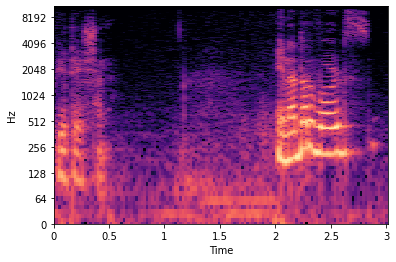

In [20]:
librosa.display.specshow(Y2[3], sr=22050, x_axis='time', y_axis='log')

(100, 1000)


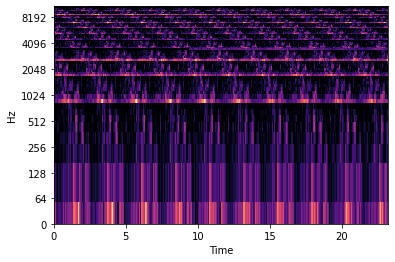

In [21]:
o = np.resize(Y2[3],(1280,1280))
o = cv2.resize(o,(1000,100))
print(o.shape)
librosa.display.specshow(o, sr=22050, x_axis='time', y_axis='log')

### DataShuffling and Processing


In [22]:
#@title test-train split
train_X = X[:960] # 70% 
train_Y = Y[:960] # 70% 

test_X = X[960:] # 30% 
test_Y = Y[960:] # 30% 

In [23]:
train_len = len(train_X)
train = []
for i in range(train_len):
  train.append((train_X[i],train_Y[i]))

In [24]:
test_len = len(test_X)
test = []
for i in range(test_len):
  test.append((test_X[i],test_Y[i]))

In [25]:
trainset = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

### All Encoder Models Instantiated

In [29]:
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

In [30]:
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, bidirectional = True):
    super(Encoder, self).__init__()
    self.hidden_size = hidden_size
    self.input_size = input_size
    self.bidirectional = bidirectional
    
    self.lstm = nn.LSTM(input_size, hidden_size, bidirectional = bidirectional)
  
  def forward(self, inputs, hidden):
    output, hidden = self.lstm(inputs.view(1, 1, self.input_size), hidden)
    return output, hidden
    
  def init_hidden(self):
    return (torch.zeros(1 + int(self.bidirectional), 1, self.hidden_size).to(device),
      torch.zeros(1 + int(self.bidirectional), 1, self.hidden_size).to(device))

In [31]:
class AttentionDecoder(nn.Module):
  
  def __init__(self, hidden_size, output_size, vocab_size):
    super(AttentionDecoder, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    
    self.attn = nn.Linear(hidden_size + output_size, 1)
    self.lstm = nn.LSTM(hidden_size + vocab_size, output_size) #if we are using embedding hidden_size should be added with embedding of vocab size
    self.final = nn.Linear(output_size, vocab_size)
  
  def init_hidden(self):
    return (torch.zeros(1, 1, self.output_size).to(device),
      torch.zeros(1, 1, self.output_size).to(device))
  
  def forward(self, decoder_hidden, encoder_outputs, input):
    weights = []
    for i in range(len(encoder_outputs)):
      #print(decoder_hidden[0][0].shape)
      #print(encoder_outputs[0].shape)
      weights.append(self.attn(torch.cat((decoder_hidden[0][0], 
                                          encoder_outputs[i]), dim = 1)))
    normalized_weights = F.softmax(torch.cat(weights, 1), 1)
    
    attn_applied = torch.bmm(normalized_weights.unsqueeze(1),
                             encoder_outputs.view(1, -1, self.hidden_size))
    
    input_lstm = torch.cat((attn_applied[0], input[0]), dim = 1) #if we are using embedding, use embedding of input here instead
    
    output, hidden = self.lstm(input_lstm.unsqueeze(0), decoder_hidden)
  
    output = self.final(output[0])
    
    return output, hidden, normalized_weights

In [61]:
class CompleteModel(nn.Module):
  def __init__(self):
    super(CompleteModel,self).__init__()
    self.bidirectional = True
   
    self.encoder_model = r3d_18
    self.encoder_model.fc = nn.Linear(in_features=512, out_features=400, bias=True)
    
    self.c = Encoder(400, 100, self.bidirectional)

    self.x = AttentionDecoder(100 * (1 + self.bidirectional), 8000, 8000)
    self.wav = waveglow
   
    
  def forward(self,x):
    resnet = self.encoder_model(x) 
    resnet = torch.squeeze(resnet)

    a, b = self.c.forward(resnet, self.c.init_hidden())
  
    y, z, w = self.x.forward(self.x.init_hidden(), torch.cat((a,a)).to(device), torch.zeros(1,1, 8000).to(device)) #Assuming <SOS> to be all zeros
    y = torch.squeeze(y)
    y = y.reshape((80,100))
    y = torch.unsqueeze(y,0)
    n = waveglow.infer(y)
    n = torch.cat((n,n,n))
    n = n.reshape((1,66150))
    return n


### Fresh stuff

In [26]:
class SeqToSeq(nn.Module):
  def __init__(self):
    super(SeqToSeq,self).__init__()

    self.encoder_model = r3d_18

    self.lstm1 = nn.LSTM(400, 400, 1, batch_first = True)

    self.TransformerEncoderLayer = nn.TransformerEncoderLayer(d_model = 400, nhead = 2, dim_feedforward=204, 
                                    dropout=0.1, activation='relu', layer_norm_eps=1e-05, 
                                    batch_first=False, norm_first=False, device='cuda', dtype=None)
    
    self.TransformerEncoder = nn.TransformerEncoder(self.TransformerEncoderLayer, num_layers = 1, norm=None, enable_nested_tensor=True)#, mask_check=True)


    #self.lstm2 = nn.LSTM(400, 4000, 1, batch_first = True)
   

    self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model = 400, nhead = 2, dim_feedforward=204, 
                                    dropout=0.1, activation='relu', layer_norm_eps=1e-05, 
                                    batch_first=False, norm_first=False, device='cuda', dtype=None)

    self.TransformerDecoder = nn.TransformerDecoder(self.TransformerDecoderLayer, num_layers = 1 , norm=None)

    
    self.Linear1 = nn.Linear(400,66150, device='cuda')
    

    #self.lstm3 = nn.LSTM(4000, 66150, 1, batch_first = True)



  def forward(self,x):
      pre_h_0 = torch.zeros(x.size(0), 400).to('cuda')
      pre_c_0 = torch.zeros(x.size(0), 400).to('cuda')

      resnet = self.encoder_model(x)

      pre_output , pre_hidden = self.lstm1(resnet,(pre_c_0,pre_h_0))
      encodings = self.TransformerEncoder(pre_output)

      #inter_h_0 = torch.zeros(x.size(0), 4000)
      #inter_c_0 = torch.zeros(x.size(0), 4000)

      #inter_output , inter_hidden = self.lstm(encodings,(inter_c_0,inter_h_0))
      decodings = self.TransformerDecoder(encodings,pre_output)

      #post_h_0 = torch.zeros(x.size(0), 66150)
      #post_c_0 = torch.zeros(x.size(0), 66150)
      post_output , post_hidden = self.lstm1(decodings,(pre_c_0,pre_h_0))
      out = self.Linear1(post_output)
      out = F.relu(out)

      return out





In [32]:
model = SeqToSeq().to(device)
#model.eval()

### Hyperparameter, Optimizer and Loss Setting

In [33]:
#@title Hyper-Parameters
num_epochs = 5
batch_size = 4
learning_rate = 0.001

In [34]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Train Loop

In [35]:
from torch.autograd import forward_ad
n_total_steps = len(trainset)


for epoch in range(num_epochs):
    for i, (seg, aud) in enumerate(trainset):
        mel = np.asarray(aud)
        #print(seg.shape,mel[0].shape)
        seg = seg.reshape((1,3,75,128,128))
        seg = seg.float()
        #print(seg.shape,seg.dtype)

        seg = seg.to(device)
        aud = aud[0].to(device)

        # Forward pass
        seq = model(seg)
        

        '''  print(encoded.shape,encoded.dtype)
        #print(encoded)

        length = encoded.T.shape
        length = torch.tensor(length)
        length = length.to(device)

        mel, _ , _ = tacotron2.infer(encoded.T,length)
      
        print(mel.shape)'''
        ''' mel = torch.unsqueeze(mel,0)
        mel = mel.to('cuda')
        print(mel.shape)
        audio = waveglow.infer(mel)
        print(audio.shape) '''
        #dummy = torch.zeros((80,100))
        #dummy = dummy.to(device)
        #print("OOO",mel.shape)
        loss = criterion(seq, aud)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.8f}')
print('Finished Training')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch [1/5], Step [2/100], Loss: 0.03261065
Epoch [1/5], Step [4/100], Loss: 0.04004634
Epoch [1/5], Step [6/100], Loss: 0.04165621
Epoch [1/5], Step [8/100], Loss: 0.04382289
Epoch [1/5], Step [10/100], Loss: 0.04192799
Epoch [1/5], Step [12/100], Loss: 0.03606557
Epoch [1/5], Step [14/100], Loss: 0.04951810
Epoch [1/5], Step [16/100], Loss: 0.05204756
Epoch [1/5], Step [18/100], Loss: 0.03111561
Epoch [1/5], Step [20/100], Loss: 0.02957474
Epoch [1/5], Step [22/100], Loss: 0.02118687
Epoch [1/5], Step [24/100], Loss: 0.05621748
Epoch [1/5], Step [26/100], Loss: 0.03610427
Epoch [1/5], Step [28/100], Loss: 0.03475698
Epoch [1/5], Step [30/100], Loss: 0.05586085
Epoch [1/5], Step [32/100], Loss: 0.02860925
Epoch [1/5], Step [34/100], Loss: 0.04243998
Epoch [1/5], Step [36/100], Loss: 0.02913817
Epoch [1/5], Step [38/100], Loss: 0.03147659
Epoch [1/5], Step [40/100], Loss: 0.04814569
Epoch [1/5], Step [42/100], Loss: 0.04935288
Epoch [1/5], Step [44/100], Loss: 0.03259313
Epoch [1/5], S

In [40]:
from IPython.display import Audio
#Audio(audio_numpy, rate=rate)

In [54]:
seg = torch.from_numpy(X[32])
seg = seg.reshape((1,3,75,128,128))
seg = seg.float()
seg = seg.to(device)
out = model(seg)
out = out.data.cpu().numpy()
Audio(out, rate=22050)
  

### Testing Loop

In [41]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for seg, aud in testset:
        seg = seg.to(device)
        aud = aud.to(device)
        outputs = model(seg)
        Audio(outputs, rate=22050)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += mel.size(0)
        n_correct += (predicted == mel).sum().item()
    print(n_correct)

0


### Save Model to \<path\>

In [ ]:
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)